# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [1]:
!nvidia-smi

Wed Sep 10 02:14:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p /content/drive/MyDrive/ML2021-hw6/

# You may replace the workspace directory if you want.
# workspace_dir = '/content/drive/MyDrive/ML2021-hw6'
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm
# Stylegan2
!pip install stylegan2_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 67.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [22]:
# get dataset from huggingface hub
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
!unzip ./MLHW_6/faces.zip -d .

串流輸出內容已截斷至最後 5000 行。
  inflating: ./faces/20071.jpg       
  inflating: ./faces/26595.jpg       
  inflating: ./faces/49584.jpg       
  inflating: ./faces/43981.jpg       
  inflating: ./faces/10666.jpg       
  inflating: ./faces/58463.jpg       
  inflating: ./faces/16295.jpg       
  inflating: ./faces/21060.jpg       
  inflating: ./faces/4403.jpg        
  inflating: ./faces/16084.jpg       
  inflating: ./faces/65220.jpg       
  inflating: ./faces/45567.jpg       
  inflating: ./faces/63132.jpg       
  inflating: ./faces/67431.jpg       
  inflating: ./faces/29426.jpg       
  inflating: ./faces/71111.jpg       
  inflating: ./faces/21515.jpg       
  inflating: ./faces/60713.jpg       
  inflating: ./faces/69169.jpg       
  inflating: ./faces/47845.jpg       
  inflating: ./faces/67653.jpg       
  inflating: ./faces/46503.jpg       
  inflating: ./faces/52996.jpg       
  inflating: ./faces/62068.jpg       
  inflating: ./faces/36319.jpg       
  inflating: ./faces/35520.jp

###Unzip the downloaded file.
The unzipped tree structure is like
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

## Random seed
Set the random seed to a certain value for reproducibility.

In [23]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1116)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [24]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [25]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

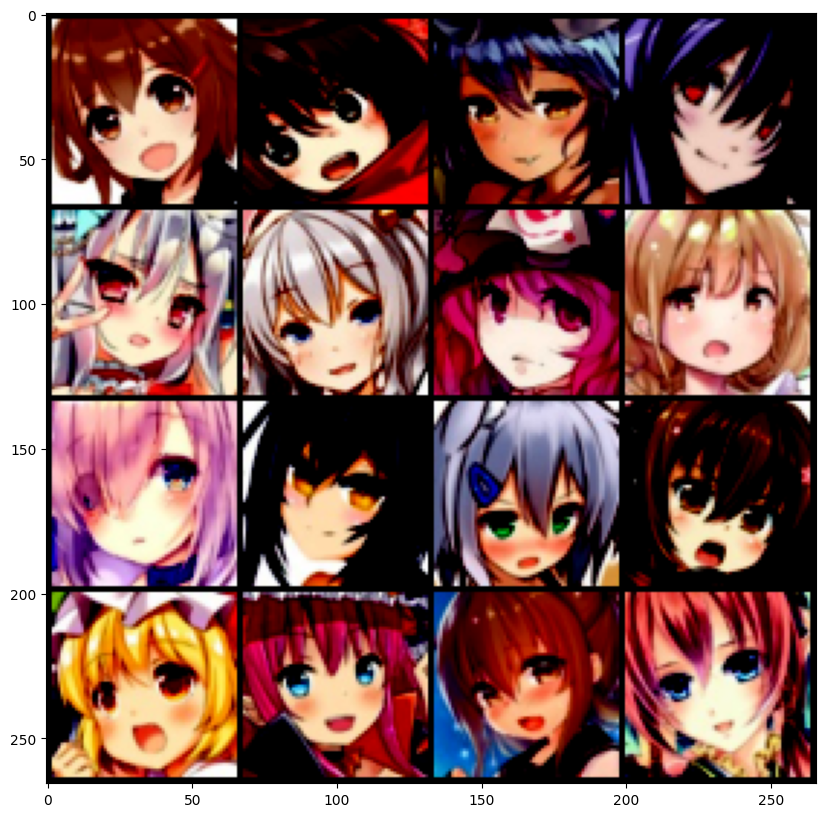

In [26]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

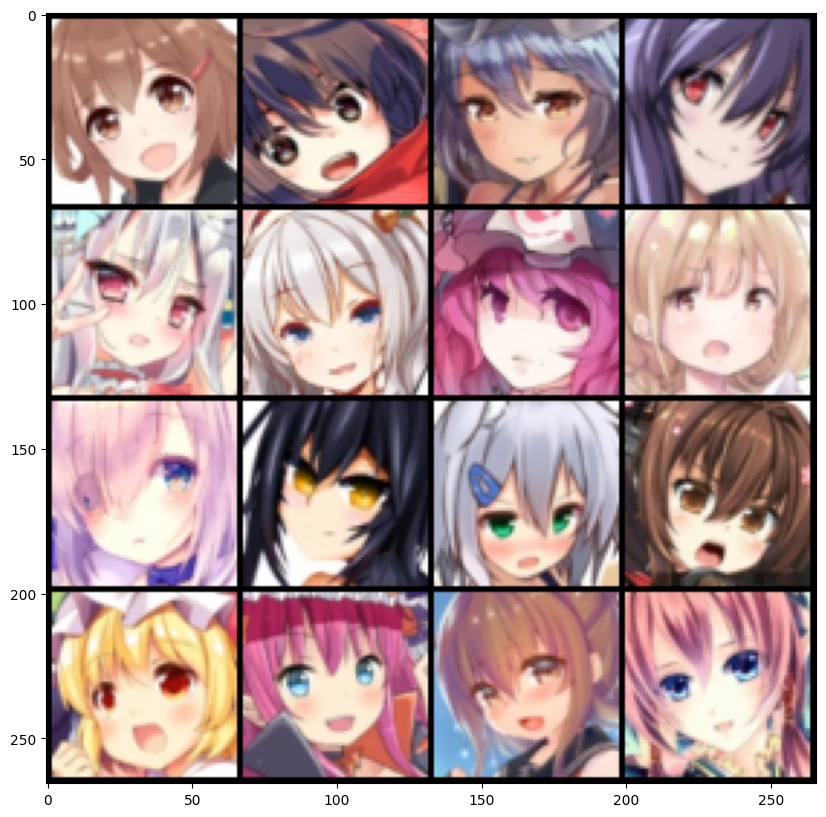

In [27]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Training

In [28]:
!export CUDA_VISIBLE_DEVICES=0

In [ ]:
!stylegan2_pytorch --data ./faces --name stylegan2 --models_dir /content/drive/MyDrive/ML2021-hw6/models --results_dir /content/drive/MyDrive/ML2021-hw6/results --image-size 64 --num-train-steps 100000

stylegan2<./faces>:   0% 0/100000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
stylegan2<./faces>:   0% 50/100000 [01:02<34:51:48,  1.26s/it]G: 0.92 | D: 1.33 | GP: 68.05
stylegan2<./faces>:   0% 100/100000 [01:59<33:01:30,  1.19s/it]G: 0.89 | D: 1.61 | GP: 45.30
stylegan2<./faces>:   0% 150/100000 [02:59<33:11:16,  1.20s/it]G: 1.68 | D: 1.85 | GP: 21.08
stylegan2<./faces>:   0% 200/100000 [03:56<32:43:27,  1.18s/it]G: 0.22 | D: 2.13 | GP: 1.67
stylegan2<./faces>:   0% 250/100000 [04:55<32:47:15,  1.18s/it]G: -2.69 | D: 2.16 | GP: 57.11
stylegan2<./faces>:   0% 300/100000 [05:53<32:35:54,  1.18s/it]G: 0.71 | D: 1.69 | GP: 3.91
stylegan2<./faces>:   

## Inference
Use the trained model to generate anime faces!

### Generate and show some images.


In [ ]:
# Generate 1000 images and make a grid to save them.
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = '/content/drive/MyDrive/ML2021-hw6',   # path to where you invoked the command line tool
    name = 'stylegan2'                             # the project name, defaults to 'default'
)


n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  # pass through mapping network

# Show 32 of the images.
imgs_sample = loader.styles_to_images(styles[:32])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [ ]:
# Save the generated images.
os.makedirs('/content/drive/MyDrive/ML2021-hw6/output/', exist_ok=True)
eval_batch_size = 100

for i in range(10):
    images = loader.styles_to_images(styles[i*eval_batch_size:(i+1)*eval_batch_size])
    for j in range(eval_batch_size):
        save_image(images[j], f'/content/drive/MyDrive/ML2021-hw6/output/{i*eval_batch_size+j+1}.jpg') # save your images, or do whatever you desire

# Compress the images.
%cd /content/drive/MyDrive/ML2021-hw6/output
!tar -zcf ../images.tgz *.jpg
%cd ..

# References

1. I modify the sample code from TA of machine learning course at NTU
2. StyleGAN2 is from https://github.com/lucidrains/stylegan2-pytorch
